In [1]:
import sympy
from sympy.abc import x, y

def velocity_field(psi):
    u = sympy.lambdify((x, y), psi.diff(y), 'numpy')
    v = sympy.lambdify((x, y), -psi.diff(x), 'numpy')
    return u, v

In [2]:
import numpy as np
from matplotlib import mlab
from scipy import integrate

def euler(f, pts, dt):
    vel = np.asarray([f(xy) for xy in pts])
    return pts + vel * dt

def rk4(f, pts, dt):
    new_pts = [mlab.rk4(f, xy, [0, dt])[-1] for xy in pts]
    return new_pts

def ode_scipy(f, pts, dt):
    new_pts = [integrate.odeint(f, xy, [0, dt])[-1] for xy in pts]
    return new_pts

available_integrators = dict(euler=euler, rk4=rk4, scipy=ode_scipy)

In [3]:
def displace_func_from_velocity_funcs(u_func, v_func, method='rk4'):
    """Return function that calculates particle positions after time step.

    Parameters
    ----------
    u_func, v_func : functions
        Velocity fields which return velocities at arbitrary coordinates.
    method : {'euler' | 'rk4' | 'scipy'}
        Integration method to update particle positions at each time step.
    """

    def velocity(xy, t=0):
        """Return (u, v) velocities for given (x, y) coordinates."""
        # Dummy `t` variable required to work with integrators
        # Must return a list (not a tuple) for scipy's integrate functions.
        return [u_func(*xy), v_func(*xy)]

    odeint = available_integrators[method]

    def displace(xy, dt):
        return odeint(velocity, xy, dt)

    return displace

In [4]:
import matplotlib.pyplot as plt
from mpltools.animation import Animation
plt.rc('contour', negative_linestyle='solid')

class StreamFuncAnim(Animation):

    def __init__(self, stream_function, dt=0.05, xlim=(-1, 1), ylim=None):
        self.dt = dt
        # Initialize velocity field and displace *functions*
        self.u, self.v = velocity_field(stream_function)
        self.displace = displace_func_from_velocity_funcs(self.u, self.v)
        # Save bounds of plot
        self.xlim = xlim
        self.ylim = ylim if ylim is not None else xlim
        # Animation objects must create `fig` and `ax` attributes.
        self.fig, self.ax = plt.subplots()
        self.ax.set_aspect('equal')

    def init_background(self):
        """Draw background with streamlines of flow.

        Note: artists drawn here aren't removed or updated between frames.
        """
        x0, x1 = self.xlim
        y0, y1 = self.ylim
        # Create 100 x 100 grid of coordinates.
        Y, X =  np.mgrid[x0:x1:100j, y0:y1:100j]
        # Horizontal and vertical velocities corresponding to coordinates.
        U = self.u(X, Y)
        V = self.v(X, Y)
        self.ax.streamplot(X, Y, U, V, color='0.7')

    def update(self):
        """Update locations of "particles" in flow on each frame frame."""
        pts = []
        while True:
            pts = list(pts)
            pts.append((self.xlim[0], random_y(self.ylim)))
            pts = self.displace(pts, self.dt)
            pts = np.asarray(pts)
            pts = remove_particles(pts, self.xlim, self.ylim)
            self.ax.lines = []

            x, y = np.asarray(pts).transpose()
            lines, = self.ax.plot(x, y, 'ro')
            yield lines, # return line so that blit works properly

In [5]:
def random_y(ylim):
    yrange = np.diff(ylim)
    return yrange * np.random.rand(1)[0] + ylim[0]

def remove_particles(pts, xlim, ylim):
    if len(pts) == 0:
        return []
    outside_xlim = (pts[:, 0] < xlim[0]) | (pts[:, 0] > xlim[1])
    outside_ylim = (pts[:, 1] < ylim[0]) | (pts[:, 1] > ylim[1])
    keep = ~(outside_xlim|outside_ylim)
    return pts[keep]

In [6]:
import sympy
from sympy.abc import x, y

radius = 1

def cylinder_stream_function(U=1, R=radius):
    r = sympy.sqrt(x**2 + y**2)
    psi = U * (r - R**2 / r) * sympy.sin(sympy.atan2(y, x))
    return psi

In [7]:
class CylinderFlow(StreamFuncAnim):
    def init_background(self):
        StreamFuncAnim.init_background(self)
        c = plt.Circle((0, 0), radius=radius, facecolor='none')
        self.ax.add_patch(c)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\animation.py", line 999, in _start
    self._init_draw()
  File "C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\animation.py", line 1746, in _init_draw
    raise RuntimeError('The init_func must return a '
RuntimeError: The init_func must return a sequence of Artist objects.


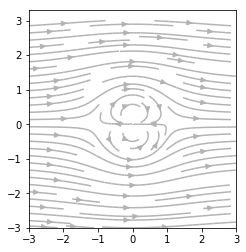

In [9]:
stream_function = cylinder_stream_function()
cylinder_flow = CylinderFlow(stream_function, xlim=(-3, 3))
cylinder_flow.animate(blit=True)
plt.show()